<a href="https://colab.research.google.com/github/tarabelo/PIAC-apuntes/blob/main/Algoritmos_Cu%C3%A1nticos_Clasicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalamos qiskit en el notebook
!pip install qiskit qiskit-aer pylatexenc

In [10]:
import numpy as np
from math import sqrt

# importing Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator, UnitarySimulator, StatevectorSimulator

# import basic plot tools
from qiskit.visualization import plot_histogram

# Funciones auxiliares

# Función para simular y mostrar el vector de estado
def obten_estado(qcirc, etiqueta="|\psi\!\!> = ", bloch=False):
    # Usamos el simulador de vector de estado
    # https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.StatevectorSimulator.html
    sim = StatevectorSimulator()
    qc_obj = transpile(qcirc, sim)
    result = sim.run(qc_obj).result()
    estado = result.get_statevector()
    display(estado.draw('latex', prefix=etiqueta))
    if bloch:
      display(estado.draw('bloch'))

# Funcion para obtener y mostrar la matriz unitaria
def obten_unitaria(qcirc, etiqueta):
    # Usamos el simulador de matriz unitaria
    # https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.UnitarySimulator.html
    sim_u = UnitarySimulator()
    qc_obj = transpile(qcirc, sim_u)
    result = sim_u.run(qcirc).result()
    unitary = result.get_unitary(qcirc)
    display(unitary.draw('latex', prefix=etiqueta))

# Algoritmos cuánticos "clásicos"

Algoritmos que presentan una ventaja real sobre sus homólogos clásicos.

Algunas características:
 - Introducidos en los años 90 del siglo XX
 - Suponen que tenemos computadores cuánticos ideales
 - Algunos de ellos carecen de utilidad práctica, mientras que otros suelen formar parte de algoritmos más complejos.

### Contenidos

1. [Paralelismo cuántico](#paralelismo)
1. [Oráculos cuánticos](#oraculo)
2. [Algoritmo de Deutsch](#deutsch)
3. [Algoritmo de Deutsch-Jozsa](#dj)
4. [Algoritmo de Bernstein-Vazirani](#bv)
4. [Algoritmo de periodicidad de Simon](#simon)
5. [Algoritmo de búsqueda de Grover: amplificación de amplitud](#grover)

# Paralelismo cuántico <a id="paralelismo"></a>

Permite evaluar una función $f(x)$ para múltiples valores de $x$ simultáneamente.

Sea $f(x): \{0,1\}\rightarrow\{0,1\}$. Para poder usar esa función en un sistema cuántico tenemos que obtener una unitaria $U_f$ que la implemente. Una forma simple es:

<center><img src="https://drive.google.com/uc?export=view&id=1wE_Ts7MoneY2S4p11SqYHT4o0_SI7vEd" alt="Puerta reversible" width="300"  /></center>

Al cúbit auxiliar $|y\rangle$ se le denomina *ancilla*


Es fácil ver que $U_f$ es su propia inversa:

<center><img src="https://drive.google.com/uc?export=view&id=1pHBMmR3su74ziSuXJK0p9zr1sAGejti_" alt="Puerta reversible demo" width="600"  /></center>

Para un sistema de dos cúbits $|yx\rangle=|y\rangle\otimes|x\rangle$ (siguiendo el orden de Qiskit) tenemos:

$$
U_f|yx\rangle = |y\oplus f(x)\rangle\otimes|x\rangle
$$

Si hacemos $|x\rangle = \tfrac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$ e $|y\rangle=|0\rangle$:

$$
\begin{aligned}
U_f\left(|0\rangle\otimes|\tfrac{1}{\sqrt{2}}(|0\rangle+|1\rangle)\rangle\right) &
= U_f\left(|\tfrac{1}{\sqrt{2}}(|00\rangle+|01\rangle)\right)
= \tfrac{1}{\sqrt{2}}\left(U_f|00\rangle+U_f|01\rangle\right) \\
& = \tfrac{1}{\sqrt{2}}\left(|0\oplus f(0)\rangle\otimes|0\rangle+|0\oplus f(1)\rangle\otimes|1\rangle\right)
= \tfrac{1}{\sqrt{2}}\left(|f(0)\rangle\otimes|0\rangle+|f(1)\rangle\otimes|1\rangle\right)
\end{aligned}
$$

Una única aplicación de $U_f$ obtiene a la vez $f(0)$ y $f(1)$.

Este resultado se puede generalizar a un estado de $n$ cubits $|\psi\rangle = \tfrac{1}{\sqrt{2^n}}\sum_{i=0}^{2^n-1} |i\rangle$:

$$
U_f\left(|0\rangle\otimes|\psi\rangle\right) = \frac{1}{\sqrt{2^n}}\sum_{i=0}^{2^n-1} |f(i)\rangle\otimes|i\rangle
$$

Se evalúan simultáneamente todos los $f(x), \forall x=0\ldots 2^{n-1}$!

&nbsp;

<details><summary>¿Sirve esto para algo?</summary>
Realmente, este paralelismo no sirve de mucho, ya que al medir solo vamos a obtener un valor de  $|i,f(i)\rangle$ (y, además, no sabemos cuál va a ser!).
</details>

# Oráculos cuánticos <a id="oraculo"></a>

Función de "caja negra" de la que solo podemos conocer su salida dada una entrada.

Los primeros algoritmos que veremos permiten extraer propiedades de un oráculo.


#### Ejemplo:

Sea una función $f(x): \{0,1\}\rightarrow\{0,1\}$. Solo hay 4 versiones de esta función:

<center><img src="https://drive.google.com/uc?export=view&id=1hLNmVOxHoBaCkN6zYnEV3YP10aXIhwJk" alt="Oráculo" width="600"  /></center>


Estas funciones pueden expresarse como matrices:

$$
f_0 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}\qquad
f_1 = \begin{bmatrix}0 & 1\\1 & 0\end{bmatrix}\qquad
f_2 = \begin{bmatrix}1 & 1\\0 & 0\end{bmatrix}\qquad
f_3 = \begin{bmatrix}0 & 0\\1 & 1\end{bmatrix}
$$

Podemos convertir esas matrices en unitarias $U_{f_i}$ para usar en el circuito anterior.

Por ejemplo, para $f_0$, podemos obtener la matriz correspondiente a $U_f$ a partir de la siguiente tabla:

<center><img src="https://drive.google.com/uc?export=view&id=1q0VWpLV2AvreY43Jms_UMfs0Ahb8tRIM" alt="Tabla f0" width="400"  /></center>


Por tanto la matriz $U_{f_0}$ es:

$$
U_{f_0} =
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 0 & 0 & 1\\
0 & 0 & 1 & 0\\
0 & 1 & 0 & 0\end{bmatrix}
$$

### Ejercicio 1

Obtén las matrices para las otras tres funciones.

-----------------------------

La matriz $U_{f_0}$ corresponde a una puerta CNOT:

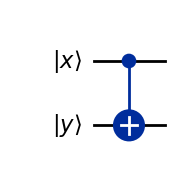

In [2]:
x = QuantumRegister(1, name="|x\\rangle")
y = QuantumRegister(1, name="|y\\rangle")
qc = QuantumCircuit(x,y)
# Aplica CNOT, primer parámetro target, segundo control
qc.cx(x,y)
qc.draw('mpl')

In [3]:
obten_unitaria(qc, "U_{f_0} = ")

<IPython.core.display.Latex object>

Qiskit permite definir este circuito como una puerta:

In [4]:
# Oráculo para f0
def f0_oraculo():
    """
    Define un oraculo para la funcion f0
        return: circuito de 2 cúbit en forma de puerta
    """
    x = QuantumRegister(1, name="|x\\rangle")
    y = QuantumRegister(1, name="|y\\rangle")
    qc = QuantumCircuit(x,y)
    # Aplica CNOT, primer parámetro target, segundo control
    qc.cx(x,y)

    oraculo = qc.to_gate()
    oraculo.name = "$U_{f_0}$"
    return(oraculo)

### Demostración del paralelismo cuántico

Podemos ver como funciona el paralelismo cuántico haciendo un circuito en Qiskit con el oraculo asociado a $f_0$.

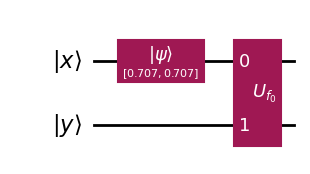

In [7]:
x = QuantumRegister(1, name="|x\\rangle")
y = QuantumRegister(1, name="|y\\rangle")
qc = QuantumCircuit(x,y)
estado_mas = Statevector([1/sqrt(2), 1/sqrt(2)])
qc.initialize(estado_mas,0)

# Añadimos el oráculo
qc = qc.compose(f0_oraculo())

qc.draw('mpl')

In [14]:
obten_estado(qc)

<IPython.core.display.Latex object>

Se trata del estado:
$$
|\psi\rangle = \tfrac{1}{\sqrt{2}}(|00\rangle+|11\rangle) = \tfrac{1}{\sqrt{2}}(|f_0(0),0\rangle+|f_1(1),1\rangle)
$$

### Ejercicio 2

Crea funciones oráculo en Qiskit para las otras 3 matrices y prueba el paralelismo cuantico en los 3 casos.

## Complejidad de consultas

En un algoritmo que hace uso de un oráculo, se denomina complejidad de consultas (*query complexity*) al número medio de *consultas* al oráculo que se necesitan para resolver el problema.

La complejidad se expresa a través de la *notación asintótica*, principalmente la notación *Big-O*.

Así, si el número $n$ de accesos al oráculo crece exponencialmente, la complejidad será $\mathcal{O}\left(2^n\right)$ y si lo hace linealmente $\mathcal{O}\left(n\right)$.

Los algoritmos cuánticos que veremos a continuación tienen una menor complejidad de consultas que sus equivalentes clásicos.